# Classification using a support vector machine

Multi-variate pattern analysis (MVPA) is becoming increasing popular in human electrophysiological research (Cichy et al., 2014; Stokes et al, 2015;). This approach allows for identifying representational specific information associated with distributed patterns of electrophysiological activity. In this example we demonstrate how a support vector machine (SVM) can be applied to classify two classes of trials.

## Preparation
Import the relevant modules:

In [2]:
# mount the drive (you'll have to click through the popup to allow it)
# google colab friendship block

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install openneuro-py
!pip install --upgrade mne-bids[full]
!pip install ipympl  # for the widgets in ipynb

clear_output()  # just clear everything because the output is gross and unnecessary

In [3]:
import os.path as op
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne_bids import BIDSPath
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

import sklearn.svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

The classification is  based on the tools in the Scikit-learn (#sklearn'#) package.

Set the local paths of the data:

In [4]:
subject = 'CB069'
session = '1'
task = 'dur'  # name of the task
run = '00'  # we have two runs for this subject, let's look at run = 1
meg_suffix = 'meg'
epo_suffix = 'epo'

deriv_root = 'drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/analysis'

bids_path = BIDSPath(subject=subject, session=session, task=task, run=run, suffix=epo_suffix, datatype='meg', root=deriv_root, extension='.fif', check=False)

print(bids_path.basename, bids_path.fpath)

sub-CB069_ses-1_task-dur_run-00_epo.fif drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/analysis/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-00_epo.fif


## Reading and preparing the trial based data
Read the epochs:

In [5]:
epochs = mne.read_epochs(bids_path.fpath, preload=True, verbose=True).pick(['meg'])

Reading /content/drive/MyDrive/GripS MEG/Data/COGITATE/derivatives/analysis/sub-CB069/ses-1/meg/sub-CB069_ses-1_task-dur_run-00_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated


Now filter the data. In this case we lowpass the data at 10 Hz. This is done before cutting the trials in shorter segments in order to reduce edge effects from the filtering. The filter also serves to perform temporal smoothing of the data which will benefit the classification.

In [6]:
epochs_rs = epochs.copy().filter(0,10)

Setting up low-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 1321 samples (1.321 s)



<ipython-input-6-5897dd76c057>:1: RuntimeWarning: filter_length (1321) is longer than the signal (701), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_rs = epochs.copy().filter(0,10)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 3041 tasks      | ela

Down-sample the data to 100 Hz in order to reduce the compuatation time. Then set the time-window of interest to -0.1 to 0.5 s around the target onset.

In [7]:
epochs_rs.resample(100)
epochs_rs.crop(tmin=-0.1, tmax=0.5)

<ipython-input-7-4cc29576044d>:2: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.49 s)
  epochs_rs.crop(tmin=-0.1, tmax=0.5)


Number of events,280
Events,face: 69false: 74latter: 66object: 71
Time range,-0.100 – 0.490 s
Baseline,off


## Setting up the classifier
The SVM is implemented in the *scikit-learn* package and the corresponding application programming interface (API) must be applied.
The matrix $X$ (features) is a three-dimensional matrix (trials  x channel x time points):


In [8]:
X = epochs_rs.get_data(picks='meg')
X.shape

(280, 306, 60)

In this case we have 256 trials and 61 times points.

The vector $y$ (also termet targets) contains 256 values indicating attention left or right trials. The trial codes (respectively 21 and 22) needs to be coverted to the values 1 and 2:

In [9]:
epochs.events

array([[ 21060,      0,   1004],
       [ 23553,      0,   1004],
       [ 25889,      0,   1002],
       [ 28140,      0,   1001],
       [ 30442,      0,   1001],
       [ 32661,      0,   1002],
       [ 34946,      0,   1004],
       [ 37656,      0,   1002],
       [ 40125,      0,   1001],
       [ 42385,      0,   1002],
       [ 44595,      0,   1003],
       [ 46864,      0,   1003],
       [ 49141,      0,   1001],
       [ 51360,      0,   1003],
       [ 54404,      0,   1004],
       [ 56639,      0,   1001],
       [ 59024,      0,   1004],
       [ 61268,      0,   1004],
       [ 63536,      0,   1003],
       [ 65847,      0,   1003],
       [ 68465,      0,   1004],
       [ 70792,      0,   1003],
       [ 73119,      0,   1002],
       [ 75430,      0,   1004],
       [ 77948,      0,   1003],
       [ 80184,      0,   1002],
       [ 82419,      0,   1002],
       [ 85596,      0,   1001],
       [ 87998,      0,   1001],
       [ 90425,      0,   1003],
       [ 9

In [10]:
temp = epochs.events[:, 2]
temp[epochs.events[:, 2] == 21] = 1
temp[epochs.events[:, 2] == 22] = 2
y = temp
print(y)

[1004 1004 1002 1001 1001 1002 1004 1002 1001 1002 1003 1003 1001 1003
 1004 1001 1004 1004 1003 1003 1004 1003 1002 1004 1003 1002 1002 1001
 1001 1003 1001 1004 1002 1004 1002 1001 1003 1003 1004 1003 1004 1001
 1001 1004 1004 1001 1002 1002 1001 1002 1002 1004 1003 1002 1004 1001
 1004 1004 1004 1001 1001 1003 1001 1003 1003 1001 1002 1002 1001 1004
 1003 1002 1002 1003 1001 1002 1001 1004 1001 1003 1004 1001 1004 1002
 1003 1004 1003 1002 1001 1002 1003 1003 1002 1001 1002 1003 1001 1004
 1004 1004 1001 1003 1002 1004 1001 1002 1004 1002 1004 1001 1004 1003
 1002 1004 1001 1002 1002 1003 1003 1001 1002 1003 1004 1004 1002 1003
 1002 1003 1004 1002 1004 1003 1002 1002 1001 1001 1001 1001 1003 1004
 1001 1004 1002 1001 1003 1003 1001 1003 1002 1003 1002 1001 1004 1001
 1002 1002 1004 1004 1004 1003 1001 1002 1003 1004 1003 1001 1002 1002
 1002 1004 1002 1002 1002 1002 1001 1002 1004 1002 1003 1004 1001 1001
 1003 1001 1003 1002 1002 1002 1001 1003 1004 1004 1001 1003 1003 1003
 1002 

The function *make_pipeline* is from *scikit-learn*. It defines the transforms used with the estimator. The *Vectorizer()* transforms X into a 2D array (samples by features).
The *StandardScaler()* standardize the data by removing the mean and scaling to unit variance.

In [11]:
clf = make_pipeline(Vectorizer(),StandardScaler(), LinearModel(sklearn.svm.SVC(kernel = 'linear')))

Finally the estimator must be defined. We here apply the *SlidingEstimator* that uses the features $X$ and targets $y$ as input as well as *clf* defining the pipeline. The aim is to discriminate the experimental conditions as functions of time; i.e. at which time points can we tell left from right attention?

In [12]:
time_decod = SlidingEstimator(clf, n_jobs=-1, verbose=True)#, scoring='roc_auc')

## Performing the classification ##
The classification will be performed timepoint by timepoint using a SVM by training on 80% of the trials on test on 20% in 5 runs. This  results in a 5-fold cross-validation (*cv=5*). The output will be reported as Area Under the Curve (AUC).

In [13]:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.2s finished


## Plotting the results
In order to plot the results, average over scores and plot:

In [14]:
scores = np.mean(scores, axis=0)

Text(0.5, 1.0, 'Sensor space decoding')

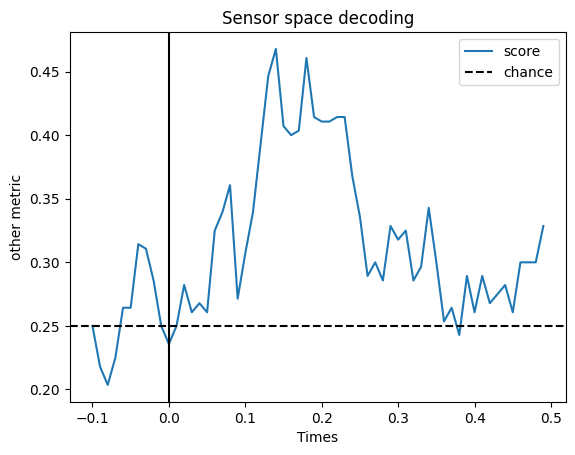

In [15]:
fig, ax = plt.subplots()
#plt.ylim([0.35, 0.65])
ax.plot(epochs_rs.times, scores, label='score')
ax.axhline(.25, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('other metric')  # Area Under the Curve not AUC
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

The plots show the accuracy (AUC) of the classification as a function of time. The best classiciation is obtained ~200 ms after the target onset and is about 0.64.


## Preregistration and publications

Publication, example:

"A multi-variate pattern analysis was applied to the MEG data to classify whether the participants attended left or right. The data were lowpass filtered at 10 Hz and then downsampled to 100 Hz. The time-points in the interval -0.1 to 0.5 s around the target onset was considered. The data were standardized by removing the mean and scaling to unit variance per sensor. A support vector machine (Cortes abd Vapnik, 1995) from Scikit-learn (https://scikit-learn.org/) was applied to classify the data as a function of time. A 5-fold cross-validation procedure was used and the classificaiton rate was reported as Area Under the Curve"

## References

* Cichy RM, Pantazis D, Oliva A.(2014) Resolving human object recognition in space and time. Nat Neurosci. 17(3):455-62. doi: 10.1038/nn.3635
* Cortes, C, Vapnik, V (1995) Support-vector networks. Mach Learn 20, 273–297
* Stokes MG, Wolff MJ, Spaak E. (2015) Decoding Rich Spatial Information with High Temporal Resolution. Trends Cogn Sci. 19(11):636-638. doi: 10.1016/j.tics.2015.08.016

